# 𝕊𝕖𝕞𝕚-𝕊𝕦𝕡𝕖𝕣𝕧𝕚𝕤𝕖𝕕 𝕝𝕖𝕒𝕣𝕟𝕚𝕟𝕘 𝕦𝕤𝕚𝕟𝕘 𝕄𝕖𝕒𝕟 𝕋𝕖𝕒𝕔𝕙𝕖𝕣

Implementation of pixel-wise Mean Teacher (MT)
    
This method is proposed in the paper: 
    'Mean Teachers are Better Role Models:
        Weight-Averaged Consistency Targets Improve Semi-Supervised Deep Learning Results'
This implementation only supports Gaussian noise as input perturbation, and the two-heads
outputs trick is not available.

Source:
https://github.com/ZHKKKe/PixelSSL/blob/master/pixelssl/ssl_algorithm/ssl_mt.py


Todo:
* [] get everything on cuda, cpu -> to configs.device
* [] metrics for segmentation + unittests
* [] track the combined loss - what's the weight, ...


Things that we have to set to the device (gpu):
* the model
* the image that gets fed into the model
* the ground truth that gets fed into the criterion
* the ground truth that gets fed into the metrics - due to activation functions


recall high: most of the roi has been segmented
in combination with low precision: general oversegmentation

Using Learning Rate Scheduler:

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/5

```
steps = 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

for epoch in range(5):
    for idx in range(steps):
        scheduler.step()
        print(scheduler.get_lr())

    print('Reset scheduler')
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
```            


* TODO
* BINARY_MODE MULTICLASS_MODE - the loss wants a different encoding ...
* ground_truth = torch.nn.functional.one_hot(ground_truth, num_classes)  # N,H*W -> N,H*W, C
* ground_truth = ground_truth.permute(0, 2, 1)  # N, C, H*W
* RuntimeError: one_hot is only applicable to index tensor.

           


# Imports

In [15]:
import glob
import os
import time
import random
from PIL import Image
import logging
import shutil # to remove dirs


import pandas as pd

import torch
import torch.nn
from torch.autograd import Variable
import torchvision
from torch.utils.tensorboard import SummaryWriter

import segmentation_models_pytorch as smp

from torch.utils.data import DataLoader

import cv2

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "helper")
from helper.dataset.meanteacher import *
# from helper.model.mean_teacher import * 
from helper.sampler.mixed_batch import *
# from helper.model.block.noise_block import GaussianNoiseBlock
from helper.compute.bin_seg import BCE_BinSeg_CU
from helper.compute.loss.shape import SignedDistanceLoss, HausdorffDTLoss
from helper.compute.loss.dice import DiceLoss
from helper.compute.metric.uncertainty import *
from helper.compute.metric.segmentation import *


#from pixelssl.utils import REGRESSION, CLASSIFICATION
#from pixelssl.utils import logger, cmd, tool
#from pixelssl.nn import func
#from pixelssl.nn.module import patch_replication_callback, GaussianNoiseLayer

# Experiment Configs

In [2]:
class Configs():
    
    def __init__(self, reset=False):
        
        
        # =============================================================================
        # CHECK THESE
        # =============================================================================
        reset_2 = True # double control, otherwise all results for this prefix will be deleted
        if reset and reset_2:
            reset=True
        else:
            reset=False
        self.prefix = "exp3_dice_cons_all_data_b7"
        self.reduced_data = False
        # "cuda" - use all the available GPUs
        # "cuda:1,3" - use specific GPUs
        self.device = "cuda" # "cuda" if torch.cuda.is_available() else "cpu"
        self.base_path = r"C:/Users/Christina/Documents/decentnet/code"
        self.print_todos = False
        self.min_save_fscore = 0.5 # 0.7
        # =============================================================================
        # CHECK THESE
        # =============================================================================
        
        # smp unet ++ parameters
        self.encoder_name = "timm-efficientnet-b7" # "efficientnet-b7"
        self.encoder_weights = "imagenet"
        self.in_channels =  1
        self.n_output_neurons = 2
        
        self.eps = 1e-6
        
        self.num_workers = 4
        self.epochs = 5000 # need more for final training ... more than 1000
        self.rampup_length = 500 # 600 for 1000
        
        # self.gaussian_noise = None # not in use
        
        self.ema_decay = 0.999 # default value
        
        # Sizes of tensors must match except in dimension 1
        # I solved the issue by resizing all the images size divisible to 32.
        self.image_size = 128 # 512
        
        # batch size = n_samples_per_class_per_batch * classes
        # for mixed batch sampling
        self.n_samples_per_class_per_batch = 4
        
        # self.lbs = 3 #  self.args.labeled_batch_size # .... remove this eventually and replace

        # optimisation
        # self.optimiser = "sgd"
        self.base_lr = 0.0001
        self.min_lr = 0.00001
        self.weight_decay = 1e-4
        self.momentum = 0.9
        
        # self.is_epoch_lrer = True # epoch or batch based learning rate updater
        
        # self.dropout = None
        
        
         
        # =============================================================================
        # Paths
        # =============================================================================
        
        
        if not os.path.exists(self.base_path):
            os.makedirs(self.base_path)
        os.chdir(self.base_path) # this is now the main directory !!!!!!!!!!!!!!!!!!!!
        
        self.csv_filenames = glob.glob(r"datasceyence-master2/data_prep/mt_*.csv")
        
        print(self.csv_filenames)
        
        # input
        self.load_checkpoint_file = None
        
        # all csv files used for run_mean_teacher.ipybn
        #self.csv_data_paths = [
        #    {"path" : r"data/data_ichallenge_amd.csv"}, 
        #    {"path" : r"data/data_ichallenge_non_amd.csv"}
        #]
        
        
        # output
        self.logger_path = f"E:/Christina/datasceyence/results/{self.prefix}/logs"
        # if path exists: delete, create path
        if reset:
            if os.path.exists(self.logger_path):
                shutil.rmtree(self.logger_path)
            os.makedirs(self.logger_path)
            
        self.result_path = os.path.join(self.logger_path, f"metrics_{self.prefix}.csv" )
            
        self.save_checkpoint_path = f"E:/Christina/datasceyence/results/{self.prefix}/ckpts"
         # if path exists: delete, create path
        if reset:
            if os.path.exists(self.save_checkpoint_path):
                shutil.rmtree(self.save_checkpoint_path)
            os.makedirs(self.save_checkpoint_path)


    def log(self):
        # =============================================================================
        # save all class variables to file "configs.txt"
        # =============================================================================
        c = pd.DataFrame.from_dict({'key': self.__dict__.keys(), 'value': self.__dict__.values()})
        c.to_csv(os.path.join(self.logger_path, "configs.txt"), sep=':', index=False)

# Routine

In [57]:
class RoutineMT:

    def __init__(self, configs):
        super(RoutineMT, self).__init__()
        
        self.configs = configs
                
        self.load_ckpt = torch.load(configs.load_checkpoint_file) if configs.load_checkpoint_file is not None else None
        
        self.i_item_total = 0
        
        
        # =============================================================================
        # Logger
        # =============================================================================
        
        self.writer =  SummaryWriter(log_dir=self.configs.logger_path)
        logging.basicConfig(filename=os.path.join(self.configs.logger_path, 'logger.log'), encoding='utf-8', level=logging.DEBUG)
        
        # =============================================================================
        # Models
        # =============================================================================
        s_model = smp.UnetPlusPlus(
                        encoder_name=self.configs.encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                        encoder_weights=self.configs.encoder_weights,  # use `imagenet` pre-trained weights for encoder initialization
                        in_channels=self.configs.in_channels,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                        classes=self.configs.n_output_neurons,         # model output channels (number of classes in your dataset)
                    )
        
        t_model = smp.UnetPlusPlus(
                        encoder_name=self.configs.encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                        encoder_weights=self.configs.encoder_weights,  # use `imagenet` pre-trained weights for encoder initialization
                        in_channels=self.configs.in_channels,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                        classes=self.configs.n_output_neurons,         # model output channels (number of classes in your dataset)
                    )
        
        # detach the teacher model
        for param in t_model.parameters():
            param.detach_()
            
        # model= nn.DataParallel(model)
        # if only one gpu ??
        if "cpu" in self.configs.device:
            self.models = {'s': s_model, 
                           't': t_model}
        else: 
            self.models = {'s': torch.nn.DataParallel(s_model).to(self.configs.device), 
                           't': torch.nn.DataParallel(t_model).to(self.configs.device)}
        
        # add gaussian noise
        # currently not in use
        # self.gaussian_noiser = GaussianNoiseBlock(self.configs.gaussian_noise).cuda()
        
        # =============================================================================
        # Computing Units
        # =============================================================================
        self.computing_unit = {
            "s_train" : BCE_BinSeg_CU(n_output_neurons=self.configs.n_output_neurons, mode="train", model="s", device=self.configs.device, writer=self.writer),
            "s_val"   : BCE_BinSeg_CU(n_output_neurons=self.configs.n_output_neurons, mode="val", model="s", device=self.configs.device, writer=self.writer),
            "t_train" : BCE_BinSeg_CU(n_output_neurons=self.configs.n_output_neurons, mode="train", model="t", device=self.configs.device, writer=self.writer),
            "s_test"  : BCE_BinSeg_CU(n_output_neurons=self.configs.n_output_neurons, mode="val", model="s", device=self.configs.device, writer=None),
        }
        
        self.top_val = { #'lowest_loss' : np.inf,  # low good
                         'highest_fscore' : self.configs.min_save_fscore, # high good
                         #'highest_jac' : 0, # high good
                         #'highest_symhd' : np.inf # low good
                     }
        
        
        
        # =============================================================================
        # Loss functions
        # =============================================================================
        # TODO: support more types of the consistency criterion
        # something with head and each head has a loss function attached??
        self.criterions = {'shape': HausdorffDTLoss(), # (device=self.configs.device, n_output_neurons=self.configs.n_output_neurons), # criterion_funcs[0](self.args),
                           'pixel': DiceLoss(n_output_neurons=self.configs.n_output_neurons),
                           'cons': torch.nn.MSELoss() # softmax missing? there is a softmax mse loss ?? todo
                          }
        
        self.um = UncertaintyMetric(n_noise=4, n_repeat=2, n_output_neurons=self.configs.n_output_neurons)
        
        # =============================================================================
        # Datasets: train, val, test
        # =============================================================================
                
        train_set = MeanTeacherTrainDataset(mode="train", channels=self.configs.in_channels, image_size=self.configs.image_size, csv_filenames=self.configs.csv_filenames, reduced_data=self.configs.reduced_data)
        train_mbs = MixedBatchSampler(train_set.get_mbs_labels(), n_samples_per_class_per_batch=self.configs.n_samples_per_class_per_batch)
        
        print("*"*50)
        print("all labels", train_set.get_mbs_labels())
        
        x = train_set.get_mbs_labels()
        leastFrequent = min(x, key=x.count)
        amount = x.count(leastFrequent)
        print("this needs some error catching")
        self.steps = int(amount/self.configs.n_samples_per_class_per_batch)
        print("steps", self.steps)
                
        val_set = MeanTeacherValDataset(mode="val", channels=self.configs.in_channels, image_size=self.configs.image_size, csv_filenames=self.configs.csv_filenames, reduced_data=self.configs.reduced_data)
        
        cir_set = MeanTeacherCirDataset(channels=self.configs.in_channels, image_size=self.configs.image_size)
              
        self.dataloader = {"train" : DataLoader(train_set, batch_sampler=train_mbs),
                           "val"   : DataLoader(val_set),
                           "cir"   : DataLoader(cir_set, shuffle=True)
                          }
        
        
        # =============================================================================
        # Optimisers
        # =============================================================================
        self.optims = {'s': torch.optim.SGD(self.models["s"].parameters(), lr=self.configs.base_lr, momentum=self.configs.momentum) # optimizer_funcs[0](self.models["s"].module.param_groups)
                          }

        # =============================================================================
        # Learning rate schedulers
        # =============================================================================
        self.lrsers = {'s': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optims["s"], 
                                                                              T_0 = 100, # number of iterations for the first restart.
                                                                              eta_min = self.configs.min_lr
                                                                               )
                     }
                  
        # =============================================================================
        # Resume training
        # =============================================================================
        if self.load_ckpt:
            self.models["s"].load_state_dict(self.load_ckpt['s_model'])
            self.models["t"].load_state_dict(self.load_ckpt['t_model'])
            self.optims["s"].load_state_dict(self.load_ckpt['s_optimizer'])
            self.lrsers["s"].load_state_dict(self.load_ckpt['s_lrer'])


    
    def run_training(self, i_epoch):
        # =============================================================================
        # Training
        # =============================================================================
        
        mode="train"
        
        self.models["s"].train()
        self.models["t"].train() # this should never be train??
        
        for i_item, item in enumerate(self.dataloader[mode]):
            # =============================================================================
            # Process Batch
            # =============================================================================
            
            # unlabelled for consistency loss
            unlabelled_batch_ids = np.where(item["has_mask"] == False) 
            # labelled for task loss
            labelled_batch_ids = np.where(item["has_mask"] == True) 
            
            # get predictions of student model for all images
            s_model_output = self.models["s"](item["img"].to(self.configs.device)) # we want all images (task loss and consistency loss)
            
            # run batch for student model
            self.computing_unit["s_train"].run_batch(configs=self.configs, criterions=self.criterions, model_output=s_model_output[labelled_batch_ids], ground_truth=item["msk"][labelled_batch_ids])
            
            if False:
                print(labelled_batch_ids)
                print(unlabelled_batch_ids)
                print("item"*40)
                print(item)
                print("item"*40)
                print("s model")
                print(s_model_output)
                print(item["msk"])
                print(s_model_output.shape)
                print(item["msk"].shape)
                print("next")

            # =============================================================================
            # Teacher Model
            # =============================================================================
            
            # forward the teacher model
            with torch.no_grad():
                # get predictions of teacher model for all images
                t_model_output = self.models["t"](item["img"].to(self.configs.device)) # we want all images (task loss and consistency loss)               
                self.computing_unit["t_train"].run_batch(configs=self.configs, criterions=self.criterions, model_output=t_model_output[labelled_batch_ids], ground_truth=item["msk"][labelled_batch_ids])
            
            
                
            if self.configs.print_todos: 
                print("run_meanteacher todo: the uncertainty mask is not good - for consistency loss")    
            # uncertainy_mask = self.um.run(self.models["t"], item["img"].to(self.configs.device))
            
            # =============================================================================
            # Consistency Loss
            # =============================================================================
            
            def sigmoid_rampup(current, rampup_length):
                # calculate the ramp-up coefficient of the consistency constraint
                # returns vavlue between 0 and 1
                # https://github.com/HiLab-git/SSL4MIS/blob/master/code/utils/ramps.py
                # Consistency ramp-up from https://arxiv.org/abs/1610.02242
                if rampup_length == 0:
                    return 1.0
                else:
                    current = np.clip(current, 0.0, rampup_length)
                    phase = 1.0 - current / rampup_length
                    return float(np.exp(-5.0 * phase * phase))
                        
            cons_weight = sigmoid_rampup(i_epoch, self.configs.rampup_length)
            
            if self.writer:
                self.writer.add_scalars("info/weight", {"cons_ramp" : cons_weight}, self.i_item_total)
            
            # calculate the consistency constraint from the teacher model to the student model
            if self.configs.print_todos: 
                print("run_meanteacher todo: here inside we have to do some beautifying of the mask - for consistency loss")
            t_pseudo_gt = t_model_output # Variable(t_model_output.detach().data, requires_grad=False)
            
            if unlabelled_batch_ids:
                cons_loss = self.criterions["cons"](s_model_output[unlabelled_batch_ids], t_pseudo_gt[unlabelled_batch_ids])
            else:
                cons_loss = self.zero_tensor
                            
            # this is a float
            threshold = torch.tensor( ( 0.75 + (0.25*sigmoid_rampup(i_epoch, self.configs.rampup_length)) * np.log(2) ) ).to(self.configs.device)
            
            
            if self.writer:
                self.writer.add_scalars("info/weight", {"thresh_ramp" : threshold.detach().cpu().numpy()}, self.i_item_total)
            
            #print(uncertainy_mask)
            #print(threshold)
            
            # this is not on the gpu ... now it is ...
            #bin_uncertainy_mask = (uncertainy_mask.to(self.configs.device) < threshold) # .float()
            
            #cons_loss_masked = torch.sum(bin_uncertainy_mask * cons_loss) / (2*torch.sum(bin_uncertainy_mask)+self.configs.eps)

            # =============================================================================
            # Backprop for student model
            # =============================================================================
            
            # combined loss
            # supervised loss + consistency loss * consistency weight
            loss = self.computing_unit["s_train"].task_loss + cons_loss * cons_weight #  + cons_loss_masked * cons_weight
            
            self.writer.add_scalars("info/loss", {"backprop" : loss,
                                                  "cons"  : cons_loss,
                                                  "cons_weighted"  : cons_loss * cons_weight,
                                                  "shape" : self.computing_unit["s_train"].shape_loss,
                                                  "pixel" : self.computing_unit["s_train"].pixel_loss}, self.i_item_total)
            
            self.optims["s"].zero_grad()
            loss.backward()
            self.optims["s"].step()      
            
            # =============================================================================
            # LR Scheduler = every batch a step
            # =============================================================================
            self.lrsers["s"].step()
            if self.writer:
                self.writer.add_scalars("info/lr", {"s_train" : self.lrsers["s"].get_last_lr()[0]}, self.i_item_total)
            
            # =============================================================================
            # EMA for teacher model
            # https://github.com/HiLab-git/SSL4MIS/blob/master/code/train_uncertainty_aware_mean_teacher_2D.py
            # https://github.com/ZHKKKe/PixelSSL/blob/master/pixelssl/ssl_algorithm/ssl_mt.py
            # =============================================================================
            local_ema_decay = min(1 - 1 / (self.i_item_total + 1), self.configs.ema_decay)
            for t_param, s_param in zip(self.models["t"].parameters(), self.models["s"].parameters()):
                # model_weights = decay * model_weights + (1 - decay) * new_model_weights
                t_param.data = t_param.data * local_ema_decay +  s_param.data * (1 - local_ema_decay)
        
            self.i_item_total += 1
        
        # =============================================================================
        # Epoch Process (basically logging)
        # =============================================================================
        self.computing_unit["s_train"].run_epoch(i_epoch=i_epoch)
        self.computing_unit["t_train"].run_epoch(i_epoch=i_epoch)
        
        

        if self.configs.print_todos: 
            print("lr")
            print(self.lrsers["s"].get_last_lr())
            print(self.lrsers["s"].get_last_lr()[0])
        
        # =============================================================================
        # Epoch log and reset (training)
        # =============================================================================
        
        if self.configs.print_todos: 
            print("training task loss")
            print(self.computing_unit["s_train"].epoch_collector["taskloss"])

            print("training fscore")
            print(self.computing_unit["s_train"].epoch_collector["fscore"])
        
        self.computing_unit["s_train"].log(csv_file_path = self.configs.result_path)
        self.computing_unit["t_train"].log(csv_file_path = self.configs.result_path)
        self.computing_unit["s_train"].reset_epoch()
        self.computing_unit["t_train"].reset_epoch()
        
        logging.info("Traning of epoch %d done" % i_epoch)

    def run_validation(self, i_epoch):
        self.models["s"].eval()
        
        # =============================================================================
        # for each batch
        # =============================================================================

        for i_item, item in enumerate(self.dataloader["val"]):
            # =============================================================================
            # Student
            # =============================================================================

            with torch.no_grad():
                # get predictions of student model for all images
                s_model_output = self.models["s"](item["img"].to(self.configs.device)) # we want all images (task loss and consistency loss)
                
                # should be based on loss function!!!!! - can we do all of them in the loss function? this is annoying
                # s_model_output = torch.nn.functional.softmax(s_model_output, dim=1) # I DON'T KNOOOOW

                # run batch for student model
                self.computing_unit["s_val"].run_batch(configs=self.configs, criterions=self.criterions, model_output=s_model_output, ground_truth=item["msk"])
        
        
        # =============================================================================
        # Epoch Process (basically logging)
        # =============================================================================
        self.computing_unit["s_val"].run_epoch(i_epoch=i_epoch)

        # =============================================================================
        # Epoch log and reset (validation)
        # =============================================================================
        
        if self.configs.print_todos: 
            print("validation task loss")
            print(self.computing_unit["s_val"].epoch_collector["taskloss"])

            print("validation fscore")
            print(self.computing_unit["s_val"].epoch_collector["fscore"])
        
        self.computing_unit["s_val"].log(csv_file_path = self.configs.result_path)
        self.computing_unit["s_val"].reset_epoch()
        
        logging.info("Validation of epoch %d done" % i_epoch)
        
    def run_final_evaluation(self, i_epoch):
                
        model = self.models["s"]
        
        paths = glob.glob(os.path.join(self.configs.save_checkpoint_path, f'checkpoint_*_{i_epoch}.ckpt'))
        
        model.load_state_dict(torch.load(paths[0])['s_model'])
        model.eval()

        for i_item, item in enumerate(self.dataloader["cir"]):

            with torch.no_grad():
                # get predictions of student model for all images
                s_model_output = self.models["s"](item["img"].to(self.configs.device)) # we want all images (task loss and consistency loss)
                
                # should be based on loss function!!!!! - can we do all of them in the loss function? this is annoying
                # s_model_output = torch.nn.functional.softmax(s_model_output, dim=1) # I DON'T KNOOOOW

                # run batch for student model
                self.computing_unit["s_test"].run_batch(configs=self.configs, criterions=self.criterions, model_output=s_model_output, ground_truth=item["msk"])
                
                print(s_model_output.shape)
                
                plt.figure()
                plt.imshow(item["img"][0].permute(1, 2, 0))
                
                
                _, highest_class = torch.max(s_model_output, 1)  
                print(highest_class.shape)
                highest_class = highest_class[0].detach().cpu().numpy()
                print(highest_class.shape)
                
                plt.figure()
                plt.imshow(highest_class, cmap="cool")
                plt.axis('off')
                plt.savefig("artefact_mask.jpg", dpi=1000)
                
                from skimage import measure
                contours = measure.find_contours(highest_class, 0.5)
                plt.figure()
                plt.imshow(item["img"][0].permute(1, 2, 0), cmap="gray")
                for contour in contours:
                    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color = 'mediumvioletred')
                plt.axis('off')
                plt.savefig("artefact.jpg", dpi=1000)

                
                plt.figure()
                plt.imshow(item["msk"][0].squeeze())
                
            break
        
        
        # =============================================================================
        # Epoch Process (basically logging)
        # =============================================================================
        self.computing_unit["s_test"].run_epoch(i_epoch=i_epoch)

        # =============================================================================
        # Epoch log and reset (validation)
        # =============================================================================
        
        print("Test task loss")
        print(self.computing_unit["s_test"].epoch_collector["taskloss"])
        
        print("Test fscore")
        print(self.computing_unit["s_test"].epoch_collector["fscore"])
        
        
        
    def log(self, i_epoch):
        # =============================================================================
        # Save checkpoint
        # =============================================================================
                
        # this cannot woooooooooooooork
        # we save the best already in the epoch .... ?
        
        #print("black magic " * 10)
        #print(self.top_val['highest_fscore'])
        #print(self.computing_unit["s_val"].top_collector["highest_fscore"] )
        
        if i_epoch > 2: #  and self.computing_unit["s_val"].epoch_collector["fscore"] > self.computing_unit["s_val"].top["highest_fscore"]:
            

            
            if self.top_val['highest_fscore'] < self.computing_unit["s_val"].top_collector["highest_fscore"]:
                
                self.top_val['highest_fscore'] = self.computing_unit["s_val"].top_collector["highest_fscore"] 
                
                #print(self.top_val['highest_fscore'])
            
                checkpoint = {
                    'name': self.configs.prefix,
                    'epoch': i_epoch, 
                    's_model': self.models["s"].state_dict(),
                    't_model': self.models["t"].state_dict(),
                    's_optim': self.optims["s"].state_dict(),
                    's_lrer': self.lrsers["s"].state_dict()
                }
                
                # self.computing_unit["s_val"].epoch_collector["fscore"]

                tmp = self.top_val['highest_fscore']
                checkpoint_path = os.path.join(self.configs.save_checkpoint_path, f'checkpoint_{tmp}_{i_epoch}.ckpt')
                torch.save(checkpoint, checkpoint_path)

                # self.computing_unit["s_val"].top["fscore"] = self.computing_unit["s_val"].epoch_collector["fscore"]

                logging.info("Saved model at epoch " + str(i_epoch) + " with fscore " + str(self.top_val['highest_fscore']))
            
        
        




# Run


# Configs
configs = Configs(reset=True)
configs.log()

# Run
run = RoutineMT(configs)

for i_epoch in range(configs.epochs):

    run.run_training(i_epoch=i_epoch)
    run.run_validation(i_epoch=i_epoch)
    run.log(i_epoch=i_epoch)

    if i_epoch == 10 and configs.reduced_data:
        break



['datasceyence-master2/data_prep\\mt_data_cirrus.csv', 'datasceyence-master2/data_prep\\mt_data_ichallenge_amd.csv', 'datasceyence-master2/data_prep\\mt_data_plex.csv']


C:\Users\Christina\Documents\decentnet\code\datasceyence-master2\helper\dataset\template.py:38: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self.csv_data = pd.concat(csv_list, axis=0, ignore_index=False)
C:\Users\Christina\Documents\decentnet\code\datasceyence-master2\helper\dataset\template.py:38: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self.csv_data = pd.concat(csv_list, axis=0, ignore_index=False)


**************************************************
all labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

C:\Users\Christina\Documents\decentnet\code\datasceyence-master2\helper\compute\loss\shape.py:235: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(loss)


torch.Size([1, 2, 128, 128])
torch.Size([1, 128, 128])
(128, 128)
{'name': 'BCE_BinSeg_CU', 'model': 's', 'mode': 'val', 'epoch': 610, 'datasize': 1, 'taskloss': 0.515, 'acc': 0.0, 'fscore': 0.0, 'jac': 0.0, 'prec': 0.0, 'rec': 1.0, 'symhd': 6.0}
Test task loss
0.515
Test fscore
0.0


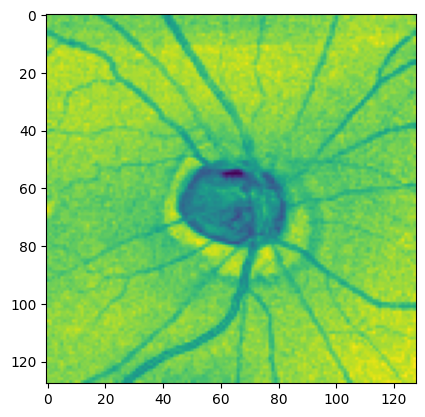

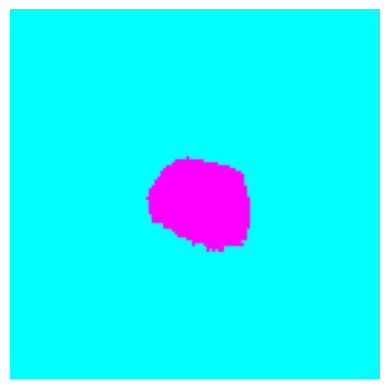

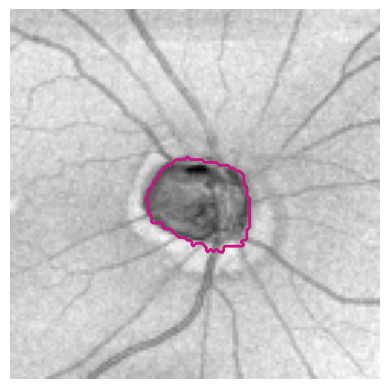

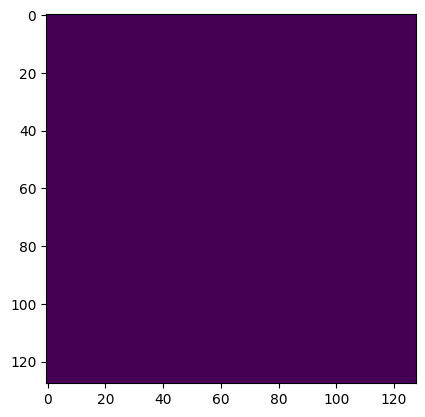

In [71]:
# Configs
configs = Configs(reset=False)
configs.log()

# Run
run = RoutineMT(configs)

i_epoch = 610

run.run_final_evaluation(i_epoch=i_epoch)


In [12]:
# tensorboard --logdir projects\decentnet\results\exp1_mt\logs port=6005   
# http://localhost:6005/?runColorGroup=regex%3A(_s_train|_s_val|_t_)#timeseries

# regex: (_s_train|_s_val|_t_)


%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir E:/Christina/datasceyence/results/exp3_dice_cons_all_data_b7/logs --port 6036

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
